<a href="https://colab.research.google.com/github/shri33/Adversarial-robustness-is-critical-for-safe-AI-deployment/blob/main/Adversarial_robustness_is_critical_for_safe_AI_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies
!pip install -q torch torchvision timm pandas matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# Random seed
torch.manual_seed(42)
np.random.seed(42)


Device: cuda


In [ ]:
# CIFAR-10
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.RandomCrop(32, padding=4),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std),
                           ]))
testset = datasets.CIFAR10(root='./data', train=False, download=True,
                          transform=transform_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

print(f"Train: {len(trainset)}, Test: {len(testset)}")


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


Train: 50000, Test: 10000


In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    loss_sum = 0.0
    correct = 0
    total = 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        _, pred = out.max(1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return loss_sum / total, correct / total

def eval_model(model, loader, criterion=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in tqdm(loader, leave=False):
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)
    return correct / total

# Train ResNet-18
resnet = models.resnet18(pretrained=False, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

best_acc = 0.0
for epoch in range(1, 31):
    tr_loss, tr_acc = train_epoch(resnet, train_loader, optimizer, criterion)
    val_acc = eval_model(resnet, test_loader)
    print(f"ResNet Ep{epoch}: TrAcc={tr_acc:.4f} ValAcc={val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(resnet.state_dict(), '/tmp/resnet_best.pth')
    scheduler.step()   # <-- this is the only line after the if

resnet.load_state_dict(torch.load('/tmp/resnet_best.pth'))
resnet_clean_acc = eval_model(resnet, test_loader)
print(f"✓ ResNet Clean Accuracy: {resnet_clean_acc:.4f}")


ResNet Ep1: TrAcc=0.3214 ValAcc=0.4383


ResNet Ep2: TrAcc=0.4625 ValAcc=0.4900


ResNet Ep3: TrAcc=0.5393 ValAcc=0.5661


ResNet Ep4: TrAcc=0.5985 ValAcc=0.6072


ResNet Ep5: TrAcc=0.6339 ValAcc=0.6550


ResNet Ep6: TrAcc=0.6610 ValAcc=0.6741


ResNet Ep7: TrAcc=0.6804 ValAcc=0.6835


ResNet Ep8: TrAcc=0.6927 ValAcc=0.7000


ResNet Ep9: TrAcc=0.7040 ValAcc=0.7081


ResNet Ep10: TrAcc=0.7152 ValAcc=0.7104


ResNet Ep11: TrAcc=0.7185 ValAcc=0.7307


ResNet Ep12: TrAcc=0.7265 ValAcc=0.6885


ResNet Ep13: TrAcc=0.7338 ValAcc=0.6871


ResNet Ep14: TrAcc=0.7366 ValAcc=0.6942


ResNet Ep15: TrAcc=0.7412 ValAcc=0.7227


ResNet Ep16: TrAcc=0.7422 ValAcc=0.6847


ResNet Ep17: TrAcc=0.7433 ValAcc=0.7433


ResNet Ep18: TrAcc=0.7487 ValAcc=0.7343


ResNet Ep19: TrAcc=0.7505 ValAcc=0.7240


ResNet Ep20: TrAcc=0.7538 ValAcc=0.7234


ResNet Ep21: TrAcc=0.8175 ValAcc=0.8235


ResNet Ep22: TrAcc=0.8379 ValAcc=0.8271


ResNet Ep23: TrAcc=0.8446 ValAcc=0.8356


ResNet Ep24: TrAcc=0.8517 ValAcc=0.8332


ResNet Ep25: TrAcc=0.8575 ValAcc=0.8357


ResNet Ep26: TrAcc=0.8611 ValAcc=0.8386


ResNet Ep27: TrAcc=0.8650 ValAcc=0.8404


ResNet Ep28: TrAcc=0.8675 ValAcc=0.8458


ResNet Ep29: TrAcc=0.8717 ValAcc=0.8456


ResNet Ep30: TrAcc=0.8734 ValAcc=0.8493


✓ ResNet Clean Accuracy: 0.8493


In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    loss_sum = 0.0
    correct = 0
    total = 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        _, pred = out.max(1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return loss_sum / total, correct / total

def eval_model(model, loader, criterion=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in tqdm(loader, leave=False):
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)
    return correct / total

# Train ResNet-18
resnet = models.resnet18(pretrained=False, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

best_acc = 0.0
for epoch in range(1, 31):
    tr_loss, tr_acc = train_epoch(resnet, train_loader, optimizer, criterion)
    val_acc = eval_model(resnet, test_loader)
    print(f"ResNet Ep{epoch}: TrAcc={tr_acc:.4f} ValAcc={val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(resnet.state_dict(), '/tmp/resnet_best.pth')
    scheduler.step()

resnet.load_state_dict(torch.load('/tmp/resnet_best.pth'))
resnet_clean_acc = eval_model(resnet, test_loader)
print(f"✓ ResNet Clean Accuracy: {resnet_clean_acc:.4f}")


ResNet Ep1: TrAcc=0.2979 ValAcc=0.4394


ResNet Ep2: TrAcc=0.4498 ValAcc=0.4996


ResNet Ep3: TrAcc=0.5298 ValAcc=0.5934


ResNet Ep4: TrAcc=0.5873 ValAcc=0.5874


ResNet Ep5: TrAcc=0.6245 ValAcc=0.6586


ResNet Ep6: TrAcc=0.6470 ValAcc=0.6600


ResNet Ep7: TrAcc=0.6723 ValAcc=0.7043


ResNet Ep8: TrAcc=0.6908 ValAcc=0.6894


ResNet Ep9: TrAcc=0.6986 ValAcc=0.7034


ResNet Ep10: TrAcc=0.7120 ValAcc=0.6518


ResNet Ep11: TrAcc=0.7135 ValAcc=0.7245


ResNet Ep12: TrAcc=0.7242 ValAcc=0.6327


ResNet Ep13: TrAcc=0.7306 ValAcc=0.7128


ResNet Ep14: TrAcc=0.7314 ValAcc=0.7276


ResNet Ep15: TrAcc=0.7343 ValAcc=0.6972


ResNet Ep16: TrAcc=0.7388 ValAcc=0.7498


ResNet Ep17: TrAcc=0.7439 ValAcc=0.7374


ResNet Ep18: TrAcc=0.7463 ValAcc=0.7301


ResNet Ep19: TrAcc=0.7486 ValAcc=0.7470


ResNet Ep20: TrAcc=0.7513 ValAcc=0.7379


ResNet Ep21: TrAcc=0.8174 ValAcc=0.8232


ResNet Ep22: TrAcc=0.8378 ValAcc=0.8264


ResNet Ep23: TrAcc=0.8456 ValAcc=0.8309


ResNet Ep24: TrAcc=0.8523 ValAcc=0.8329


ResNet Ep25: TrAcc=0.8548 ValAcc=0.8360


ResNet Ep26: TrAcc=0.8610 ValAcc=0.8316


ResNet Ep27: TrAcc=0.8623 ValAcc=0.8377


ResNet Ep28: TrAcc=0.8673 ValAcc=0.8348


ResNet Ep29: TrAcc=0.8704 ValAcc=0.8373


ResNet Ep30: TrAcc=0.8740 ValAcc=0.8387


✓ ResNet Clean Accuracy: 0.8387


In [ ]:
!pip install -q timm==0.9.16

import timm
print([m for m in timm.list_models('vit_*')[:20]])



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.8 MB/s eta 0:00:00
['vit_7b_patch16_dinov3', 'vit_base_mci_224', 'vit_base_patch8_224', 'vit_base_patch14_dinov2', 'vit_base_patch14_reg4_dinov2', 'vit_base_patch16_18x2_224', 'vit_base_patch16_224', 'vit_base_patch16_224_miil', 'vit_base_patch16_384', 'vit_base_patch16_clip_224', 'vit_base_patch16_clip_384', 'vit_base_patch16_clip_quickgelu_224', 'vit_base_patch16_dinov3', 'vit_base_patch16_dinov3_qkvb', 'vit_base_patch16_gap_224', 'vit_base_patch16_plus_240', 'vit_base_patch16_plus_clip_240', 'vit_base_patch16_reg4_gap_256', 'vit_base_patch16_rope_224', 'vit_base_patch16_rope_ape_224']


In [ ]:
from torchvision import transforms

mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform_train_224 = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test_224 = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset_224 = datasets.CIFAR10(root='./data', train=True, download=True,
                                transform=transform_train_224)
testset_224  = datasets.CIFAR10(root='./data', train=False, download=True,
                                transform=transform_test_224)

train_loader_224 = torch.utils.data.DataLoader(trainset_224, batch_size=128,
                                               shuffle=True, num_workers=2)
test_loader_224  = torch.utils.data.DataLoader(testset_224, batch_size=256,
                                              shuffle=False, num_workers=2)


In [ ]:
import timm
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ViT model available in timm
vit = timm.create_model('vit_tiny_patch16_224', pretrained=False,
                        num_classes=10).to(device)

optimizer = optim.AdamW(vit.parameters(), lr=1e-3, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
for epoch in range(1, 31):
    tr_loss, tr_acc = train_epoch(vit, train_loader_224, optimizer, criterion)
    val_acc = eval_model(vit, test_loader_224)
    print(f"ViT Ep{epoch}: TrAcc={tr_acc:.4f} ValAcc={val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(vit.state_dict(), '/tmp/vit_best.pth')
    scheduler.step()

vit.load_state_dict(torch.load('/tmp/vit_best.pth'))
vit_clean_acc = eval_model(vit, test_loader_224)
print(f"✓ ViT Clean Accuracy: {vit_clean_acc:.4f}")


ViT Ep1: TrAcc=0.3027 ValAcc=0.3810


ViT Ep2: TrAcc=0.4092 ValAcc=0.4299


ViT Ep3: TrAcc=0.4597 ValAcc=0.4677


ViT Ep4: TrAcc=0.4954 ValAcc=0.5044


ViT Ep5: TrAcc=0.5219 ValAcc=0.5032


ViT Ep6: TrAcc=0.5458 ValAcc=0.5584


ViT Ep7: TrAcc=0.5743 ValAcc=0.5770


ViT Ep8: TrAcc=0.5908 ValAcc=0.5921


ViT Ep9: TrAcc=0.6160 ValAcc=0.5929


ViT Ep10: TrAcc=0.6364 ValAcc=0.6142


ViT Ep11: TrAcc=0.6626 ValAcc=0.6168


ViT Ep12: TrAcc=0.6838 ValAcc=0.6503


ViT Ep13: TrAcc=0.7040 ValAcc=0.6746


ViT Ep14: TrAcc=0.7249 ValAcc=0.6925


ViT Ep15: TrAcc=0.7433 ValAcc=0.6954


ViT Ep16: TrAcc=0.7627 ValAcc=0.7095


ViT Ep17: TrAcc=0.7774 ValAcc=0.7167


ViT Ep18: TrAcc=0.7979 ValAcc=0.7254


ViT Ep19: TrAcc=0.8163 ValAcc=0.7259


ViT Ep20: TrAcc=0.8353 ValAcc=0.7261


ViT Ep21: TrAcc=0.8552 ValAcc=0.7336


ViT Ep22: TrAcc=0.8718 ValAcc=0.7270


ViT Ep23: TrAcc=0.8917 ValAcc=0.7354


ViT Ep24: TrAcc=0.9089 ValAcc=0.7332


ViT Ep25: TrAcc=0.9247 ValAcc=0.7364


ViT Ep26: TrAcc=0.9373 ValAcc=0.7365


ViT Ep27: TrAcc=0.9476 ValAcc=0.7368


ViT Ep28: TrAcc=0.9568 ValAcc=0.7382


ViT Ep29: TrAcc=0.9624 ValAcc=0.7355


ViT Ep30: TrAcc=0.9641 ValAcc=0.7360


✓ ViT Clean Accuracy: 0.7382


In [ ]:
def fgsm_attack(model, x, y, epsilon):
    model.eval()
    x_adv = x.clone().detach().requires_grad_(True)
    out = model(x_adv)
    loss = criterion(out, y)
    model.zero_grad()
    loss.backward()
    grad = x_adv.grad.data
    x_adv = x_adv + epsilon * torch.sign(grad)
    return torch.clamp(x_adv, 0, 1).detach()

def pgd_attack(model, x, y, epsilon, alpha=2/255, iters=7):
    model.eval()
    x_orig = x.clone().detach()
    x_adv = x_orig + torch.zeros_like(x_orig).uniform_(-epsilon, epsilon)
    x_adv = torch.clamp(x_adv, 0, 1).detach()

    for _ in range(iters):
        x_adv.requires_grad_(True)
        out = model(x_adv)
        loss = criterion(out, y)
        model.zero_grad()
        loss.backward()
        grad = x_adv.grad.data
        x_adv = x_adv + alpha * torch.sign(grad)
        x_adv = torch.max(torch.min(x_adv, x_orig + epsilon), x_orig - epsilon)
        x_adv = torch.clamp(x_adv, 0, 1).detach()

    return x_adv

def eval_adv_acc(model, loader, attack_fn, eps):
    model.eval()
    correct = 0
    total = 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)

        # adversarial example generation (needs gradients)
        x_adv = attack_fn(model, x, y, eps)

        # evaluation on adversarial examples (no gradients needed)
        with torch.no_grad():
            out = model(x_adv)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)
    return correct / total

# Evaluate
epsilons = [2/255, 4/255, 8/255, 16/255]
results = {'epsilon': [], 'ResNet_FGSM': [], 'ResNet_PGD': [],
           'ViT_FGSM': [], 'ViT_PGD': []}

for eps in epsilons:
    print(f"\n=== ε = {eps:.4f} ({int(eps*255)}/255) ===")
    results['epsilon'].append(eps)

    # ResNet uses 32x32 loader
    r_fgsm = eval_adv_acc(resnet, test_loader,      fgsm_attack, eps)
    r_pgd  = eval_adv_acc(resnet, test_loader,      pgd_attack, eps)
    results['ResNet_FGSM'].append(r_fgsm)
    results['ResNet_PGD'].append(r_pgd)
    print(f"ResNet: FGSM={r_fgsm:.4f} PGD={r_pgd:.4f}")

    # ViT uses 224x224 loader
    v_fgsm = eval_adv_acc(vit,   test_loader_224,   fgsm_attack, eps)
    v_pgd  = eval_adv_acc(vit,   test_loader_224,   pgd_attack, eps)
    results['ViT_FGSM'].append(v_fgsm)
    results['ViT_PGD'].append(v_pgd)
    print(f"ViT:    FGSM={v_fgsm:.4f} PGD={v_pgd:.4f}")

df = pd.DataFrame(results)
print("\n" + "="*70)
print(df.to_string(index=False))
df.to_csv('results.csv', index=False)




=== ε = 0.0078 (2/255) ===


ResNet: FGSM=0.4604 PGD=0.4114


ViT:    FGSM=0.2843 PGD=0.1423

=== ε = 0.0157 (4/255) ===


ResNet: FGSM=0.4341 PGD=0.3274


ViT:    FGSM=0.2536 PGD=0.0618

=== ε = 0.0314 (8/255) ===


ResNet: FGSM=0.3800 PGD=0.2111


ViT:    FGSM=0.2036 PGD=0.0178

=== ε = 0.0627 (16/255) ===


ResNet: FGSM=0.2912 PGD=0.1454


ViT:    FGSM=0.1425 PGD=0.0077

 epsilon  ResNet_FGSM  ResNet_PGD  ViT_FGSM  ViT_PGD
0.007843       0.4604      0.4114    0.2843   0.1423
0.015686       0.4341      0.3274    0.2536   0.0618
0.031373       0.3800      0.2111    0.2036   0.0178
0.062745       0.2912      0.1454    0.1425   0.0077


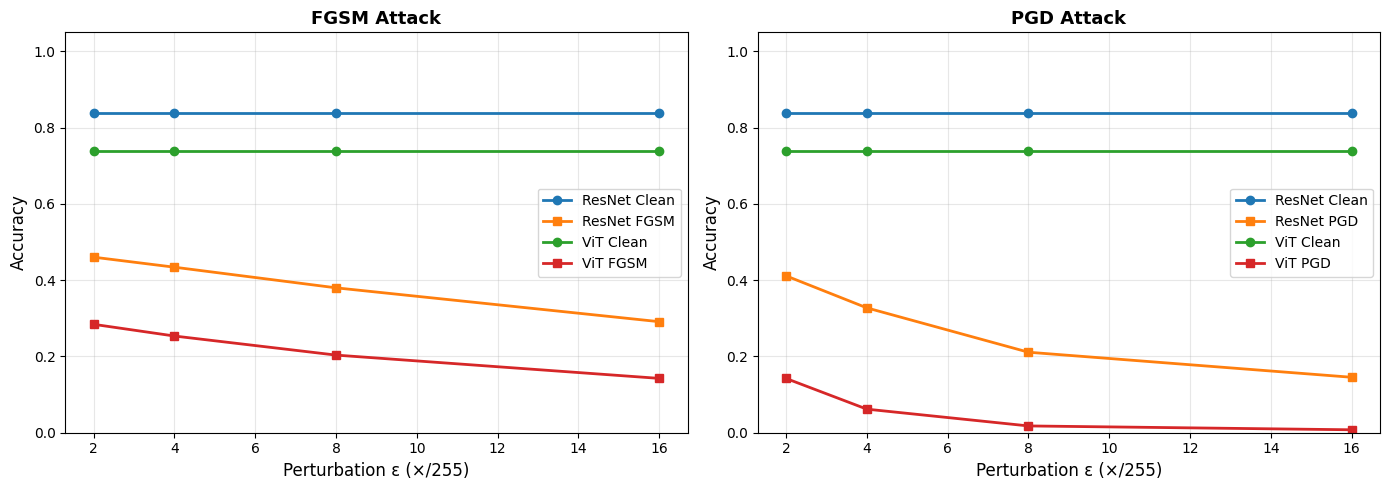

✓ Plots saved


In [ ]:
import matplotlib.pyplot as plt

eps_int = [int(e*255) for e in results['epsilon']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# FGSM
ax1.plot(eps_int, [resnet_clean_acc]*len(eps_int), 'o-', label='ResNet Clean', lw=2)
ax1.plot(eps_int, results['ResNet_FGSM'], 's-', label='ResNet FGSM', lw=2)
ax1.plot(eps_int, [vit_clean_acc]*len(eps_int), 'o-', label='ViT Clean', lw=2)
ax1.plot(eps_int, results['ViT_FGSM'], 's-', label='ViT FGSM', lw=2)
ax1.set_xlabel('Perturbation ε (×/255)', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('FGSM Attack', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_ylim([0, 1.05])

# PGD
ax2.plot(eps_int, [resnet_clean_acc]*len(eps_int), 'o-', label='ResNet Clean', lw=2)
ax2.plot(eps_int, results['ResNet_PGD'], 's-', label='ResNet PGD', lw=2)
ax2.plot(eps_int, [vit_clean_acc]*len(eps_int), 'o-', label='ViT Clean', lw=2)
ax2.plot(eps_int, results['ViT_PGD'], 's-', label='ViT PGD', lw=2)
ax2.set_xlabel('Perturbation ε (×/255)', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('PGD Attack', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('robustness_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Plots saved")
